In [ ]:
!pip install openrouteservice haversine geopy folium branca tensorflow tensorflow_recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
######################################################
# cargamos las librerias generales de lectura de datos
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.patches import Ellipse
import time

# cargamos la libreria que nos permite medir la distancia data la latitud y longitud
from haversine import haversine_vector, Unit, inverse_haversine, Direction

# cargamos las librerias de reoreferencia
from geopy.geocoders import Nominatim
import folium
import folium.plugins as plugins
import branca
import openrouteservice

# cargamos las librerias del recomendador
from typing import Dict, Text
import tensorflow as tf
import tensorflow_recommenders as tfrs


from google.colab import drive
drive.mount('/content/drive')


# cargamos nuestras funciones que usaremos en pasos posteriores
#from utils import random_point

# no mostramos los warnings
#import warnings
#warnings.filterwarnings('ignore')

In [ ]:
client = openrouteservice.Client(key='5b3ce3597851110001cf624862ecd46263a04e1db3b3a412aabcf6de')

In [ ]:
# lectura de las bases de datos de directorio que contiene la informacion para cada colegio
path_directorio_og = '/content/drive/MyDrive/DOCUMENTOS_TESIS_JAVIERA_JORQUERA/CODIGOS_FINAL/'

df_directorio_all= pd.read_csv(path_directorio_og+'Directorio_Colegios/df_directorio_all_clean.csv',sep=';')
df_directorio_all

# Definicion de Funciones

In [ ]:
def random_point(a, b):
    '''
    Esta funcion genera numeros random dentro de una elipse centrada en 0.
    Cuyas dimensiones son a y b

    INPUTS:
        dimensiones a y b de la ellipse.

    OUTPUTS:
        a y b random.
    '''
    d = np.math.radians(random.random()*360)
    return (a * np.math.cos(d) * random.random(), b * np.math.sin(d) * random.random())

In [ ]:
def gen_objetive_selection(tipo_colegio, genero_alumno, lat, long, id_nivel, df_directorio_all, distancia_a_evaluar = 4, number_of_points=1000, seleccion_colegios=[]):
    '''
    Esta funcion permite generar postulaciones de forma automatica
    Basandonos en criterios de desempeño de los alumnos para cada uno de los colegios
    A la salida obtendremos una seleccion similar a la generada hoy en dia en base al SAE
    Pero con informacion objetiva extraida de las bases de datos.

    INPUTS:

    tipo_colegio      = LISTA o ESCALAR / identificador codigo depe 2 del tipo de colegio al cual esta postulando (1 municipal, 2 particular subencionado, 3 particular pagado).
    genero_alumno     = ESCALAR / genero del alumno que postula (1=H o 2=M).
    lat               = ESCALAR / coordenada de latitud de referencia del alumno o direccion a consultar.
    long              = ESCALAR / coordenada de longitud de referencia del alumno o direccion a consultar.
    id_nivel          = ESCALAR / identificador si es de basica o media (1-8 basica o 9-12 media).
    selecion_colegios = LISTA o VACIO / lista de RBD de los colegios seleccionados en orden de prioridad.
    distancia_en_km   = ESCALAR / distancia en kilometros a evaluar en la busqueda.
    number_of_points  = ESCALAR / numero de postulaciones a generar.
    df_directorio_all = DATAFRAME / todo el directorio con la informacion de cada uno de los colegios de la RM.

    OUTPUTS:
    df_list_of_selection = DATAFRAME / con las seleciones del numero de postulaciones requeridas.

    '''

    # como es primero basico no se consideran los porcentaje del demre
    df_analisis = df_directorio_all[(df_directorio_all.COD_NIVEL==id_nivel) & (df_directorio_all.COD_DEPE2.isin(tipo_colegio))].copy()
    list_of_selection = []

    # el radio de la tierra es
    r = 6371 # km

    # calculamos las distancias
    coo2 = list(tuple(map(tuple,np.array(df_analisis[['LATITUD','LONGITUD']]))))
    coo1 = (lat , long)
    coo1 = ((coo1, ) * len(coo2))
    d = haversine_vector(coo1, coo2, Unit.KILOMETERS)
    # seleccionamos los colegios que estan a menos de 4 kilometros
    df_analisis['DISTANCIA'] = d;

    # para la generacion de los numeros random voy a usar solo los que estan a dos kilomestros de distancia
    # quiero calcular el equivalente a un radio de 1/2 de la distancia
    coo1_ref1 = inverse_haversine((coo1[0][0],coo1[0][1]), distancia_a_evaluar/2, Direction.WEST)
    coo1_ref2 = inverse_haversine((coo1[0][0],coo1[0][1]), distancia_a_evaluar/2, Direction.NORTH)

    # distancia euclideana entre coo1 y coo1_ref 1 y 2
    d1 = np.sqrt((coo1[0][0] - coo1_ref1[0])**2. + (coo1[0][1] - coo1_ref1[1])**2.)
    d2 = np.sqrt((coo1[0][0] - coo1_ref2[0])**2. + (coo1[0][1] - coo1_ref2[1])**2.)

    # generamos coordenadas aleatorias dentro de ese rango de busqueda
    points = [random_point(d2, d1) for i in range(number_of_points)]
    x, y = zip(*points)
    x = np.array(x) + coo1[0][0]
    y = np.array(y) + coo1[0][1]



    ## declaro la elipse que voy a mostrar
    #el = Ellipse(xy=(coo1[0][0], coo1[0][1]), width=d2*2, height=d1*2, edgecolor='m', fc='None', lw=2)
    #
    #if genero_alumno == 1:
    #    df_temp = df_analisis[(df_analisis.DISTANCIA<=distancia_a_evaluar) & (df_analisis.GEN_H==1)]
    #if genero_alumno == 2:
    #    df_temp = df_analisis[(df_analisis.DISTANCIA<=distancia_a_evaluar) & (df_analisis.GEN_M==1)]

    ## mostramos apra estar seguros que esta bien la seleccion
    #fig, ax = plt.subplots(figsize=(10,10))
    #ax.plot(coo1[0][0], coo1[0][1],'*b')
    #ax.plot(coo1_ref1[0], coo1_ref1[1],'*g')
    #ax.plot(coo1_ref2[0], coo1_ref2[1],'*k')
    #ax.plot(df_temp.LATITUD,df_temp.LONGITUD,'*r', markersize=10)
    #ax.scatter(x, y)
    #ax.add_patch(el)
    #ax.set_xlabel('Latitud')
    #ax.set_ylabel('Longitud')
    #ax.set_title('coordenadas lat_long')
    #ax.grid(True)
    #plt.show()

    # debo normalizar los datos entre 0 y 1 para cada categoria del data frame df_temp1
    # LOS PRIMEROS 4 PARAMETROS TENDRAN UN PESO DE 50% EN LA MAXIMIZACION
    df_analisis['PROM'] = (df_analisis['PROM']/np.nanmax(df_analisis['PROM']))*0.1
    df_analisis['ASIS'] = (df_analisis['ASIS']/np.nanmax(df_analisis['ASIS']))*0.1
    df_analisis['APRB'] = (df_analisis['APRB']/np.nanmax(df_analisis['APRB']))*0.1
    df_analisis['NOND'] = (df_analisis['NOND']/np.nanmax(df_analisis['NOND']))*0.1
    df_analisis['PEND'] = ((df_analisis['PEND'] + np.abs(np.nanmin(df_analisis['PEND'])))/np.nanmax((df_analisis['PEND'] + np.abs(np.nanmin(df_analisis['PEND'])))))*0.1

    # LOS PARAMETROS RELACIONADOS CON EL SIMSE TENDRAN UN PESO DE 25% EN LA MAXIMIZACION
    df_analisis['SIMCE-LEC'] = df_analisis['SIMCE-LEC']/np.nanmax(df_analisis['SIMCE-LEC'])*0.0625
    df_analisis['SIMCE-MAT'] = df_analisis['SIMCE-MAT']/np.nanmax(df_analisis['SIMCE-MAT'])*0.0625
    df_analisis['PEND-LEC'] = ((df_analisis['PEND-LEC'] + np.abs(np.nanmin(df_analisis['PEND-LEC'])))/np.nanmax((df_analisis['PEND-LEC'] + np.abs(np.nanmin(df_analisis['PEND-LEC'])))))*0.0625
    df_analisis['PEND-MAT'] = ((df_analisis['PEND-MAT'] + np.abs(np.nanmin(df_analisis['PEND-MAT'])))/np.nanmax((df_analisis['PEND-MAT'] + np.abs(np.nanmin(df_analisis['PEND-MAT'])))))*0.0625

    # LOS PARAMETROS RELACIONADOS CON EL INGRESO A LA UNIVERSIDAD TENDRAN UN 25% EN LA MAXIMIZACION
    # ESTAS 4 ULTIMAS SOLO SERAN INTEGRADAS PARA LOS CURSOS DE 1RO A CUARTO MEDIO
    df_analisis['PROM-PUNT'] = df_analisis['PROM-PUNT']/np.nanmax(df_analisis['PROM-PUNT'])*0.0625
    df_analisis['PROM-POST'] = df_analisis['PROM-POST']/np.nanmax(df_analisis['PROM-POST'])*0.0625
    df_analisis['DE-F-YEAR'] = df_analisis['DE-F-YEAR']/np.nanmax(df_analisis['DE-F-YEAR'])*0.0625
    df_analisis['PORC-MATR'] = df_analisis['PORC-MATR']/np.nanmax(df_analisis['PORC-MATR'])*0.0625

    # Esta sera la metrica del score asignado por la persona para cada uno de los colegios
    if id_nivel>=1 & id_nivel<=8:
        df_analisis['SUM'] = df_analisis[['PROM','ASIS','APRB','NOND','PEND','SIMCE-LEC','SIMCE-MAT','PEND-LEC','PEND-MAT']].sum(axis=1, skipna=True)

    if id_nivel>=9 & id_nivel<=12:
        df_analisis['SUM'] = df_analisis[['PROM','ASIS','APRB','NOND','PEND','SIMCE-LEC','SIMCE-MAT','PEND-LEC','PEND-MAT','PROM-PUNT','PROM-POST','DE-F-YEAR','PORC-MATR']].sum(axis=1, skipna=True)

    # el score ira de 1 a 5, donde el valor mas alto tendra un 5 y el valor mas bajo tendra un 1
    # verificamos los limites
    limites = np.linspace(np.nanmin(df_analisis['SUM']),np.nanmax(df_analisis['SUM']),6)
    df_analisis['RANKING'] = df_analisis['SUM']
    df_analisis['RANKING'] = np.where(df_analisis['SUM'].between(limites[0],limites[1]), 1, df_analisis['RANKING'])
    df_analisis['RANKING'] = np.where(df_analisis['SUM'].between(limites[1],limites[2]), 2, df_analisis['RANKING'])
    df_analisis['RANKING'] = np.where(df_analisis['SUM'].between(limites[2],limites[3]), 3, df_analisis['RANKING'])
    df_analisis['RANKING'] = np.where(df_analisis['SUM'].between(limites[3],limites[4]), 4, df_analisis['RANKING'])
    df_analisis['RANKING'] = np.where(df_analisis['SUM'].between(limites[4],limites[5]), 5, df_analisis['RANKING'])

    ########################################################################################################################################################
    ########################################################################################################################################################
    # seleccionamos colegios
    if len(seleccion_colegios)==0:
        # este codigo es valido solo cuando entregamos una direccion como busqueda, donde no tenemos una seleccion previa.
        if genero_alumno == 1:
            colegios_seleccionados = df_analisis[(df_analisis.DISTANCIA<=distancia_a_evaluar) & (df_analisis.GEN_H==1)]
        if genero_alumno == 2:
            colegios_seleccionados = df_analisis[(df_analisis.DISTANCIA<=distancia_a_evaluar) & (df_analisis.GEN_M==1)]

        if colegios_seleccionados.shape[0]>5:
            colegios_seleccionados = colegios_seleccionados.sort_values(by=['DISTANCIA'], ascending=True)[0:5]
        else:
            colegios_seleccionados = colegios_seleccionados.sort_values(by=['DISTANCIA'], ascending=True)[0:]
        list_of_selection.append((tipo_colegio, genero_alumno, np.array(colegios_seleccionados['RBD']), np.array(colegios_seleccionados['RANKING'])))

    if len(seleccion_colegios)>0:

        # este codigo es valido solo cuando entregamos una direccion como busqueda, donde no tenemos una seleccion previa.
        if genero_alumno == 1:
            colegios_seleccionados = df_analisis[(df_analisis.RBD.isin(seleccion_colegios)) & (df_analisis.GEN_H==1)]
        if genero_alumno == 2:
            colegios_seleccionados = df_analisis[(df_analisis.RBD.isin(seleccion_colegios)) & (df_analisis.GEN_M==1)]

        list_of_selection.append((tipo_colegio, genero_alumno, np.array(colegios_seleccionados['RBD']), np.array(colegios_seleccionados['RANKING'])))

    ########################################################################################################################################################
    ########################################################################################################################################################
    # en base a estas coordenadas aleatorias voy a generar un nuevo dataframe de seleccion en base a las variables objetivas extraidas de las bases de datos
    for n in range(x.shape[0]):
        coordenada2 = coo2
        coordenada1 = (x[n] , y[n])
        coordenada1 = ((coordenada1, ) * len(coordenada2))
        distancia = haversine_vector(coordenada1, coordenada2, Unit.KILOMETERS)
        df_analisis['DISTANCIA_NEW'] = distancia;

        # seleccionamos los colegios que estan a menos de 4 kilometros /2
        dataframe_temp = df_analisis[df_analisis.DISTANCIA_NEW<=distancia_a_evaluar/2]

        if dataframe_temp.shape[0]>1:

            dataframe_temp = dataframe_temp.reset_index(drop=True)

            # limites para seleccionar un nuevo ranking
            limites = np.linspace(np.nanmin(dataframe_temp['SUM']),np.nanmax(dataframe_temp['SUM']),6)
            dataframe_temp['RANKING'] = dataframe_temp['SUM']
            dataframe_temp['RANKING'] = np.where(dataframe_temp['SUM'].between(limites[0],limites[1]), 1, dataframe_temp['RANKING'])
            dataframe_temp['RANKING'] = np.where(dataframe_temp['SUM'].between(limites[1],limites[2]), 2, dataframe_temp['RANKING'])
            dataframe_temp['RANKING'] = np.where(dataframe_temp['SUM'].between(limites[2],limites[3]), 3, dataframe_temp['RANKING'])
            dataframe_temp['RANKING'] = np.where(dataframe_temp['SUM'].between(limites[3],limites[4]), 4, dataframe_temp['RANKING'])
            dataframe_temp['RANKING'] = np.where(dataframe_temp['SUM'].between(limites[4],limites[5]), 5, dataframe_temp['RANKING'])

            # aqui hacemos una seleccion inicial de colegios sin importar ninguna de las 4 categorias
            df_temp1 =  dataframe_temp[['RBD', 'NOM_RBD','COD_DEPE2', 'GEN_H', 'GEN_M','PAGO_MENSUAL','ORI_RELIGIOSA','SUM','RANKING']].copy()

            for tipo in df_temp1.COD_DEPE2.unique(): # iteramos sobre el tipo de colegio
                df_temp2 = df_temp1[df_temp1.COD_DEPE2==tipo].copy()

                # considero los colegios que poseen solo hombres o mixtos
                if genero_alumno == 1:
                    df_temp3 = df_temp2[df_temp2.GEN_H==1].copy()
                    df_temp3 = df_temp3.sort_values(by=['SUM'], ascending=False)
                    list_of_selection.append((tipo, 1, np.array(df_temp3['RBD'][0:df_temp3.shape[0]]), np.array(df_temp3['RANKING'][0:df_temp3.shape[0]])))

                if genero_alumno == 2:
                # considero los colegios que poseen solo mujeres o mixtos
                    df_temp3 = df_temp2[df_temp2.GEN_M==1].copy()
                    df_temp3 = df_temp3.sort_values(by=['SUM'], ascending=False)
                    list_of_selection.append((tipo, 2, np.array(df_temp3['RBD'][0:df_temp3.shape[0]]), np.array(df_temp3['RANKING'][0:df_temp3.shape[0]])))

    # PASAMOS CADA UNA DE LAS VARIABLES GENERADAS ANTERIORMENTE A UN DATAFRAME
    id_alumno = []
    id_cod_depe2 = []
    id_cod_genero = []
    id_seleccion_rbd = []
    id_rating_rbd = []
    for idx,sub_list in enumerate(list_of_selection):
        for number,rating in zip(sub_list[2], sub_list[3]):
            if idx == 0:
                id_alumno.append(idx+1)
                id_cod_depe2.append(df_analisis[df_analisis.RBD==number]['COD_DEPE2'].iloc[0])
                id_cod_genero.append(sub_list[1])
                id_seleccion_rbd.append(number)
                id_rating_rbd.append(rating)
            else:
                id_alumno.append(idx+1)
                id_cod_depe2.append(sub_list[0])
                id_cod_genero.append(sub_list[1])
                id_seleccion_rbd.append(number)
                id_rating_rbd.append(rating)


    # DATAFRAME FINAL
    '''
    Este data frame contiene lo siguiente:

    user_id = identificador del postulante
    cod_depe2 = identificador del tipo de establecimiento
    genero = genero del postulante
    item_id = RBD seleccionado
    id_rating_rhd = prioridad seleccion RBD

    '''
    df_list_of_selection = pd.DataFrame({'user_id':id_alumno,'cod_depe2':id_cod_depe2,'genero':id_cod_genero,'item_id':id_seleccion_rbd, 'rating':id_rating_rbd})

    ## PARA EL ALUMNO 1 DEBO CORREGIR EL CODIGO DEPE YA QUE PUEDE POSTULAR A MUNICIPALES Y PARTICULARES SUBENCIONADOS A LA VES
    #for idx in range(df_list_of_selection[df_list_of_selection.user_id==1].shape[0]):
    #    rbd_temp = df_list_of_selection[df_list_of_selection.user_id==1].item_id.iloc[idx]
    #    df_list_of_selection['cod_depe2'][idx] = df_directorio_all[(df_directorio_all.RBD==rbd_temp) & (df_directorio_all.COD_NIVEL==id_nivel)].COD_DEPE2.iloc[0]


    return df_list_of_selection

In [ ]:
def data_normalization(df_list_of_selection, df_directorio_all, id_nivel):
    '''
    Esta funcion normaliza los rating con respecto al valor maximo de rating que encuentra en el data frame

    INPUTS:

    df_list_of_selection = DATAFRAME / con la seleccion de colegios generadas a partir de valores objetivos
    df_directorio_all    = DATAFRAME / todo el directorio con la informacion de cada uno de los colegios de la RM.
    id_nivel             = ESCALAR / identificador si es de basica o media (1-8 basica o 9-12 media).

    OUTPUT:

    ratings = postulaciones en formato dataframe nombre del colegio y identificador del postulante
    school = colegios disponibles identificador y nombre del colegio.
    '''

    ###############################################################################################
    # este valor servira para reescalar el rating
    # debido a que el ranking depende la prioridad de seleccion
    # tensor flow necesita que el ranking mayor tenga una mayor prioridad, en cambio el SAE 1 significa mayor prioridad.
    # seleccionamos el numero maximo de colegios en la seleccion
    maximo_numero_de_colegios_seleccionados = df_list_of_selection['user_id'].value_counts().max()

    ###############################################################################################
    # cambiamos de orden las prioridades seleccionadas
    #df_list_of_selection.rating = (df_list_of_selection.rating - (maximo_numero_de_colegios_seleccionados+1))*(-1)
    ratings = df_list_of_selection.copy()
    ratings = ratings.rename(columns={'rating':'user_rating'})


    ###############################################################################################
    # directorio para el nivel analizado
    df_analisis = df_directorio_all[df_directorio_all.COD_NIVEL==id_nivel].copy()

    ###############################################################################################
    # ordenamos los datos de los colegios para que sean compatibles con los formatos de tensorflow
    # colegios disponibles
    schools_availables = list(ratings.item_id.unique())

    # transfiero el data frame del directorio
    school = df_analisis[['RBD','NOM_RBD']].rename(columns={'RBD':'item_id', 'NOM_RBD':'school_name'})

    # solo selecciono los colegios que a los cuales los alumnos postularon en este radio de busqueda
    school = school[school['item_id'].isin(schools_availables)]
    school_df = school.reset_index(drop=True)

    ###############################################################################################
    # juntamos las postulaciones con los colegios
    ratings = pd.merge(ratings, school_df, on='item_id')

    # nos quedamos soloc on la columna nombre colegio y id usuario
    ratings_df = ratings[['school_name', 'user_id', 'user_rating']].reset_index(drop=True)

    return ratings_df, school_df

In [ ]:
class RankingModel(tf.keras.Model):
    '''
    Este codigo calcula los embeding en base de los ranking entregado.
    '''

    def __init__(self):
        super().__init__()
        embedding_dimension = 64

        # Calculamos los embeding para los usuarios
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Calculamos los embeding para las escuelas
        self.school_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
            vocabulary=unique_school_names, mask_token=None),
            tf.keras.layers.Embedding(len(unique_school_names) + 1, embedding_dimension)
        ])

        # Calculamos las predicciones
        self.ratings = tf.keras.Sequential([
            # Multiples capas de aprendisaje densas
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            # Realizamos las predicciones en la capa final.
            tf.keras.layers.Dense(1)
        ])

    def call(self, inputs):

        user_id, school_name = inputs

        user_embedding = self.user_embeddings(user_id)
        school_embedding = self.school_embeddings(school_name)

        return self.ratings(tf.concat([user_embedding, school_embedding], axis=1))

In [ ]:
class SchoolRecommendation(tfrs.models.Model):
    '''
    Este codigo ejecuta el modelo
    '''
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["user_id"], features["school_name"]))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("user_rating")

        rating_predictions = self(features)

        # Este codigo computa el rmse y el loss.
        return self.task(labels=labels, predictions=rating_predictions)

In [ ]:
def popup_html(df, tipo, ori_rel, id_mostrar):

    if id_mostrar == 1:
        institucion_name = df['NOM_RBD']
        institucion_tipo = tipo[df['COD_DEPE2']-1]
        cost = df['PAGO_MENSUAL']
        religion = ori_rel[df['ORI_RELIGIOSA']-1]
        rango_nivel = df['RANGO_NIVEL']
        genero_alumnos = df['GEN_COL']

        left_col_color = "#19a7bd"
        right_col_color = "#f2f0d3"

        html = """<!DOCTYPE html>
    <html>
    <head>
    <h4 style="margin-bottom:10"; width="200px">{}</h4>""".format(institucion_name) + """



    </head>
        <table style="height: 150px; width: 400px;">
    <tbody>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Tipo</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(institucion_tipo.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Valor Mensual</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(cost.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Religión</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(religion.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Niveles Impartidos</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(rango_nivel.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Genero Alumnos(as)</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(genero_alumnos.upper()) + """
    </tr>
    </tbody>
    </table>
    </html>
    """
    if id_mostrar ==2:
        institucion_name = df['NOM_RBD']
        institucion_tipo = tipo[df['COD_DEPE2']-1]
        cost = df['PAGO_MENSUAL']
        religion = ori_rel[df['ORI_RELIGIOSA']-1]
        rango_nivel = df['RANGO_NIVEL']
        genero_alumnos = df['GEN_COL']
        distancia = df['DISTANCIA']

        nota_colegio = df['SUM'].astype(str)
        score_mf = df['SCORE'].astype(str)

        left_col_color = "#19a7bd"
        right_col_color = "#f2f0d3"

        html = """<!DOCTYPE html>
    <html>
    <head>
    <h4 style="margin-bottom:10"; width="200px">{}</h4>""".format(institucion_name) + """
    </head>
        <table style="height: 150px; width: 400px;">
    <tbody>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Tipo</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(institucion_tipo.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Valor Mensual</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(cost.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Religión</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(religion.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Niveles Impartidos</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(rango_nivel.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Genero Alumnos(as)</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(genero_alumnos.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Puntaje Colegio</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(nota_colegio.upper()) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Distancia [KM]</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(round(distancia, 2)) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Score MF</span></td>
    <td style="width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(score_mf.upper()) + """
    </tr>
    </tbody>
    </table>
    </html>
    """
    return html

In [ ]:
def colegios(direccion, radio_de_busqueda, df_DIRECTORIO, id_mostrar):
    '''
    direccion = calle número, comuna, ciudad, país
    radio_de_busqueda = radio en kilometros
    '''
    if df_DIRECTORIO.shape[0]>=1:
        # calling the Nominatim tool
        loc = Nominatim(user_agent="GetLoc", timeout=50)

        # entering the location name
        getLoc = loc.geocode(direccion)
        if not getLoc:
            print("No se pudo geolocalizar la dirección")
            return

        # printing address
        print("Dirección = ", getLoc.address)
        # printing latitude and longitude
        print("Latitude = ", getLoc.latitude)
        print("Longitude = ", getLoc.longitude)

        address = (getLoc.latitude,getLoc.longitude)

        # eliminamos los establecimientos sin latitud y longitud
        #df_DIRECTORIO.dropna(how='any',axis=0,inplace=True)
        df_DIRECTORIO.reset_index(inplace=True, drop=True)

        # tenemos entonces la latitud y longitud de la direccion
        # y calculamos la distancia entre las coordinadas en millas.
        # si queremos pasarla a kilometros usamos d*1.609344
        # page: https://www.geeksforgeeks.org/program-distance-two-points-earth/
        # addres es la direcion de la casa

        # el radio de la tierra es
        r = 6371 # km

        # calculamos las distancias
        coo2 = list(tuple(map(tuple,np.array(df_DIRECTORIO[['LATITUD','LONGITUD']]))))
        coo1 = (address[0] , address[1])
        coo1 = ((coo1, ) * len(coo2))
        #print(address)
        #print(coo1)
        #print(coo2)
        d = haversine_vector(coo1, coo2, Unit.KILOMETERS)
        # seleccionamos los colegios que estan a menos de 4 kilometros
        df_DIRECTORIO['DISTANCIA'] = d


        # voy a mostrar solo colegios particulares, particulares subencionados y municipales.
        # COD_DEPE2 = 1 (Municipal), 2 (Particular Subvencionado), 3 (Particular Pagado)
        # De enseñanza basica y medica, niños y jovenes, sin discapacidad, horario diurno
        # ENS_01 = 110,310,410,510,610,710,810,910

        mask1 = df_DIRECTORIO['DISTANCIA']<radio_de_busqueda
        mask2 = (df_DIRECTORIO['COD_DEPE2']==1) | (df_DIRECTORIO['COD_DEPE2']==2) | (df_DIRECTORIO['COD_DEPE2']==3)
        mask3 = (df_DIRECTORIO['ENS_01']==10) | (df_DIRECTORIO['ENS_01']==110) | (df_DIRECTORIO['ENS_01']==310) | (df_DIRECTORIO['ENS_01']==410) | (df_DIRECTORIO['ENS_01']==510) | (df_DIRECTORIO['ENS_01']==610) | (df_DIRECTORIO['ENS_01']==710) | (df_DIRECTORIO['ENS_01']==810) | (df_DIRECTORIO['ENS_01']==910)

        # generamos un nuevo dataframe filtrado
        df_DIRECTORIO_F = df_DIRECTORIO[mask1 & mask2 & mask3]
        df_DIRECTORIO_F.reset_index(inplace=True, drop=True)

        # 1: Municipal, 2: Particular Subvencionado, 3: Particular Pagado, 4: Corp. De Administración Delegada, 5: Servicio Local de Educación
        ori_rel = ['Laica',
                   'Católica',
                   'Evangelica',
                   'Musulmana',
                   'Judia',
                   'Budista',
                   'Otro',
                   'nada',
                   'Sin Información']

        tipo_colors = ['green','orange', 'red', 'gray', 'yellow']
        tipo = ['Municipal','Particular Subvencionado','Particular Pagado','Corp. De Administración Delegada','Servicio Local de Educación']
        tipo_letra = ['M','S','P','C','L']


        m = folium.Map(location=address, zoom_start=15, tiles='CartoDB positron')

        # agregamos el circulo de busqueda en la figura
        folium.Circle(location=address,
                      radius=radio_de_busqueda*1000,
                      popup=str(radio_de_busqueda) + ' kms',
                      color='lightblue',
                      fill_color='lightblue').add_to(m)

        direccion_html = """<!DOCTYPE html>
        <html>
        <head>
        <h5 style="margin-bottom:10"; width="200px">{}</h5>""".format(direccion) + """
        </head>
        </html>"""

        # el marcado de la direccion de referencia
        folium.Marker([getLoc.latitude, getLoc.longitude],
                      popup=direccion_html,
                      icon=folium.Icon(color="blue", icon="home")).add_to(m)

        if id_mostrar==1:
            # agregamos los marcadores de colegios encontrados
            print(df_DIRECTORIO_F.shape)
            for idx in range(df_DIRECTORIO_F.shape[0]):
                df = df_DIRECTORIO_F.iloc[idx]
                html = popup_html(df, tipo, ori_rel, id_mostrar)
                # el marcado de la direccion de referencia
                folium.Marker([df['LATITUD'], df['LONGITUD']],
                              popup=folium.Popup(folium.Html(html, script=True), max_width=500),
                              #icon=folium.Icon(color=tipo_colors[df['COD_DEPE2']-1], icon='info', prefix='fa')).add_to(m)
                              icon=plugins.BeautifyIcon(
                                     icon="arrow-down", icon_shape="marker",
                                     number=tipo_letra[df['COD_DEPE2']-1],
                                     border_color= tipo_colors[df['COD_DEPE2']-1],
                                     background_color=tipo_colors[df['COD_DEPE2']-1])).add_to(m)
        else:

            #############################################################################################################################
            #############################################################################################################################
            # agregamos los marcadores de colegios encontrados
            df_DIRECTORIO_F1 = df_DIRECTORIO_F[df_DIRECTORIO_F.ID_OS==2] # colegios sigeridos
            df_DIRECTORIO_F1 = df_DIRECTORIO_F1.reset_index(drop=True)
            df_DIRECTORIO_F1 = df_DIRECTORIO_F1.sort_values(by=['SCORE'], ascending=False)


            df_DIRECTORIO_F2 = df_DIRECTORIO_F[df_DIRECTORIO_F.ID_OS==1] # colegios originales
            df_DIRECTORIO_F2 = df_DIRECTORIO_F2.reset_index(drop=True)

            #############################################################################################################################
            #############################################################################################################################
            for idx in range(df_DIRECTORIO_F1.shape[0]):
                df = df_DIRECTORIO_F1.iloc[idx]
                html = popup_html(df, tipo, ori_rel, id_mostrar)

                if df.RBD in list(df_DIRECTORIO_F2.RBD):
                    coords = ((loc.geocode(direccion).longitude,loc.geocode(direccion).latitude),(df['LONGITUD'], df['LATITUD']))
                    res = client.directions(coords)
                    geometry = client.directions(coords)['routes'][0]['geometry']
                    decoded = openrouteservice.convert.decode_polyline(geometry)

                    folium.GeoJson(
                        decoded,
                        style_function= lambda feature: {
                            "color": 'blue',
                            "weight": 2,
                            "opacity": 0.3
                            },
                        highlight_function= lambda feature: {
                            "weight": 4,
                            "opacity": 1,
                        },
                        marker = folium.Marker([df['LATITUD'], df['LONGITUD']],
                                      popup=folium.Popup(folium.Html(html, script=True), max_width=500),
                                      #icon=folium.Icon(color=tipo_colors[df['COD_DEPE2']-1], icon='info', prefix='fa')).add_to(m)
                                      icon=plugins.BeautifyIcon(
                                             icon="arrow-down", icon_shape="marker",
                                             number=tipo_letra[df['COD_DEPE2']-1] + str(idx+1) + '*',
                                             border_color= tipo_colors[df['COD_DEPE2']-1],
                                             background_color = tipo_colors[df['COD_DEPE2']-1])).add_to(m),
                        smooth_factor=5,
                        ).add_to(m)

                else:
                    coords = ((loc.geocode(direccion).longitude,loc.geocode(direccion).latitude),(df['LONGITUD'], df['LATITUD']))
                    res = client.directions(coords)
                    geometry = client.directions(coords)['routes'][0]['geometry']
                    decoded = openrouteservice.convert.decode_polyline(geometry)

                    folium.GeoJson(
                        decoded,
                        style_function= lambda feature: {
                            "color": 'blue',
                            "weight": 2,
                            "opacity": 0.3
                            },
                        highlight_function= lambda feature: {
                            "weight": 4,
                            "opacity": 1,
                        },
                        marker = folium.Marker([df['LATITUD'], df['LONGITUD']],
                                      popup=folium.Popup(folium.Html(html, script=True), max_width=500),
                                      #icon=folium.Icon(color=tipo_colors[df['COD_DEPE2']-1], icon='info', prefix='fa')).add_to(m)
                                      icon=plugins.BeautifyIcon(
                                             icon="arrow-down", icon_shape="marker",
                                             number=tipo_letra[df['COD_DEPE2']-1] + str(idx+1),
                                             border_color= tipo_colors[df['COD_DEPE2']-1],
                                             background_color = tipo_colors[df['COD_DEPE2']-1])).add_to(m),
                        smooth_factor=5,

                        ).add_to(m)



                #marker.add_child(folium.ClickForMarker(popup="toggleGeoJson()"))


            '''
            for idx in range(df_DIRECTORIO_F2.shape[0]):
                df = df_DIRECTORIO_F2.iloc[idx]
                html = popup_html(df, tipo, ori_rel, id_mostrar)

                if df.RBD not in list(df_DIRECTORIO_F1.RBD):
                    # el marcado de la direccion de referencia
                    folium.Marker([df['LATITUD'], df['LONGITUD']],
                                  popup=folium.Popup(folium.Html(html, script=True), max_width=500),
                                  #icon=folium.Icon(color=tipo_colors[df['COD_DEPE2']-1], icon='info', prefix='fa')).add_to(m)
                                  icon=plugins.BeautifyIcon(
                                         icon = "arrow-down", icon_shape="marker",
                                         number = tipo_letra[df['COD_DEPE2']-1],
                                         border_color = 'magenta',
                                         background_color = 'magenta')).add_to(m)
            '''



    else:
        print('No se encontraron colegios con las caracteristicas solicitadas.')

        # calling the Nominatim tool
        loc = Nominatim(user_agent="GetLoc", timeout=50)

        # entering the location name
        getLoc = loc.geocode(direccion)

        # printing address
        print("Dirección = ", getLoc.address)
        # printing latitude and longitude
        print("Latitude = ", getLoc.latitude)
        print("Longitude = ", getLoc.longitude)

        address = (getLoc.latitude,getLoc.longitude)

        m = folium.Map(location=address, zoom_start=13,tiles='CartoDB positron')

        # agregamos el circulo de busqueda en la figura
        folium.Circle(location=address,
                      radius=radio_de_busqueda*1000,
                      popup=str(radio_de_busqueda) + ' kms',
                      color='blue',
                      fill_color='blue').add_to(m)

        direccion_html = """<!DOCTYPE html>
        <html>
        <head>
        <h5 style="margin-bottom:10"; width="200px">{}</h5>""".format(direccion) + """
        </head>
        </html>"""

        # el marcado de la direccion de referencia
        folium.Marker([getLoc.latitude, getLoc.longitude],
                      popup=direccion_html,
                      icon=folium.Icon(color="blue", icon="home")).add_to(m)

    return m

# Primero cargamos las caracteristicas entregadas por el usuario

Para el modelo generado via direccion de entrada utilizamos lo siguiente.

#Testing originales

## Ejemplo direccion 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Rosario Sur 600, Las Condes, Santiago'
radio_de_busqueda = 6

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

## Ejemplo direccion 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Lira 245, Santiago, Santiago'
radio_de_busqueda = 4

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000


## Ejemplo direccion 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Los Sargazos 1235, Viña del Mar, Valparaíso'
radio_de_busqueda = 6

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 9 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

## Ejemplo direccion 3

In [ ]:
########################################################################################
# escribo la direccion de busqueda
direccion = 'Diego de Almagro 1700-1798, Arica, Arica y Parinacota'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 9 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Los Lilenes 2015-2091, Iquique, Tarapacá'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Av. Manuel Rodríguez 600, Concepción'
radio_de_busqueda = 4

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Rengifo 752-802, Puerto Montt, Los Lagos'
radio_de_busqueda = 4

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Carlos Condell 501, Punta Arenas, Magallanes y la Antártica Chilena'
radio_de_busqueda = 4

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Los Avellanos 2255, Ñuñoa, Santiago'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

#Testing Validación

##I Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Aníbal Pinto 600, Iquique, Tarapacá'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Aníbal Pinto 600, Iquique, Tarapacá'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Aníbal Pinto 600, Iquique, Tarapacá'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO", "$1.000 A $10.000", "$10.001 A $25.000", "$25.001 A $50.000", "$50.001 A $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Aníbal Pinto 600, Iquique, Tarapacá'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000


###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Aníbal Pinto 600, Iquique, Tarapacá'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##II Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Antonio José de Sucre 499, Antofagasta'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Antonio José de Sucre 499, Antofagasta'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO", "$1.000 A $10.000", "$10.001 A $25.000", "$25.001 A $50.000", "$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Antonio José de Sucre 499, Antofagasta'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Antonio José de Sucre 499, Antofagasta'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Antonio José de Sucre 499, Antofagasta'
radio_de_busqueda = 2
#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##III Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Los Carrera 801, Copiapó, Atacama'
radio_de_busqueda = 4

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Los Carrera 801, Copiapó, Atacama'
radio_de_busqueda = 4

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Los Carrera 801, Copiapó, Atacama'
radio_de_busqueda = 4

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Los Carrera 801, Copiapó, Atacama'
radio_de_busqueda = 4

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Los Carrera 801, Copiapó, Atacama'
radio_de_busqueda = 4
#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = [] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##IV Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Regidor Muñoz 392, La Serena, Coquimbo'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Regidor Muñoz 392, La Serena, Coquimbo'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Regidor Muñoz 392, La Serena, Coquimbo'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [2, 3] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO", "$10.001 A $25.000", "$25.001 A $50.000","$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Regidor Muñoz 392, La Serena, Coquimbo'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Regidor Muñoz 392, La Serena, Coquimbo'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##V Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Independencia 2112, Valparaíso'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Independencia 2112, Valparaíso'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Independencia 2112, Valparaíso'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Independencia 2112, Valparaíso'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "$50.001 A $100.000","MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = 'Independencia 2112, Valparaíso'
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [3] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##VI Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "German Riesco 292, Rancagua, O'Higgins"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "German Riesco 292, Rancagua, O'Higgins"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "German Riesco 292, Rancagua, O'Higgins"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "German Riesco 292, Rancagua, O'Higgins"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "German Riesco 292, Rancagua, O'Higgins"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##VII Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Isidoro del Solar 135, Talca, Maule"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Isidoro del Solar 135, Talca, Maule"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Isidoro del Solar 135, Talca, Maule"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3, 2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO", "$1.000 A $10.000", "$10.001 A $25.000", "$25.001 A $50.000", "$50.001 A $100.000","$50.001 A $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Isidoro del Solar 135, Talca, Maule"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["$50.001 A $100.000", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Isidoro del Solar 135, Talca, Maule"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##VIII Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Manuel Rodríguez 408, Concepción, Provincia de Concepción, Región del Biobío, Chile"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Manuel Rodríguez 408, Concepción, Provincia de Concepción, Región del Biobío, Chile"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Manuel Rodríguez 408, Concepción, Provincia de Concepción, Región del Biobío, Chile"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Manuel Rodríguez 408, Concepción, Provincia de Concepción, Región del Biobío, Chile"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "$50.001 A $100.000", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Av. Manuel Rodríguez 408, Concepción, Provincia de Concepción, Región del Biobío, Chile"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##IX Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Antonio Varas 545, Temuco, Araucanía"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Antonio Varas 545, Temuco, Araucanía"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Antonio Varas 545, Temuco, Araucanía"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Antonio Varas 545, Temuco, Araucanía"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Antonio Varas 545, Temuco, Araucanía"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##X Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Benavente 402, Puerto Montt, Los Lagos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Benavente 402, Puerto Montt, Los Lagos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Benavente 402, Puerto Montt, Los Lagos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1,2,6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "$1.000 A $10.000", "$10.001 A $25.000", "$25.001 A $50.000","$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Benavente 402, Puerto Montt, Los Lagos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Benavente 402, Puerto Montt, Los Lagos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

## XI Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Eusebio Lillo 119, Coyhaique, Aysén"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Eusebio Lillo 119, Coyhaique, Aysén"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Eusebio Lillo 119, Coyhaique, Aysén"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO", "$50.001 A $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Eusebio Lillo 119, Coyhaique, Aysén"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Eusebio Lillo 119, Coyhaique, Aysén"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1, 2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##XII Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Hernando de Magallanes 975, Punta Arenas, Magallanes y la Antártica Chilena"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Hernando de Magallanes 975, Punta Arenas, Magallanes y la Antártica Chilena"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Hernando de Magallanes 975, Punta Arenas, Magallanes y la Antártica Chilena"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Hernando de Magallanes 975, Punta Arenas, Magallanes y la Antártica Chilena"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2,3] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","$50.001 A $100.000","MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Hernando de Magallanes 975, Punta Arenas, Magallanes y la Antártica Chilena"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##XIII Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Merced 774, Santiago, Región Metropolitana"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Merced 774, Santiago, Región Metropolitana"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Merced 774, Santiago, Región Metropolitana"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Merced 774, Santiago, Región Metropolitana"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Merced 774, Santiago, Región Metropolitana"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##XIV Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Varela 711, Valdivia, Los Ríos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Varela 711, Valdivia, Los Ríos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Varela 711, Valdivia, Los Ríos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO", "$1.000 A $10.000", "$10.001 A $25.000", "$25.001 A $50.000", "$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Varela 711, Valdivia, Los Ríos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "Varela 711, Valdivia, Los Ríos"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##XV Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "San Bernardo 2504, Arica, Arica y Parinacota"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "San Bernardo 2504, Arica, Arica y Parinacota"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "San Bernardo 2504, Arica, Arica y Parinacota"
radio_de_busqueda = 3

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO", "$25.001 A $50.000","$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "San Bernardo 2504, Arica, Arica y Parinacota"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "San Bernardo 2504, Arica, Arica y Parinacota"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [3] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

##XVI Region

###Usuario 1

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "18 de Septiembre 727, Chillán, Ñuble"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 1 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = []# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 2

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "18 de Septiembre 727, Chillán, Ñuble"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 7 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [2,1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [1, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION","GRATUITO"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 3

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "18 de Septiembre 727, Chillán, Ñuble"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 11 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [2, 6] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO", "$1.000 A $10.000", "$10.001 A $25.000", "$25.001 A $50.000", "$50.001 A $100.000", "MAS DE $100.000"]# SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 4

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "18 de Septiembre 727, Chillán, Ñuble"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 2 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 1 # 1 = hombre, 2 = mujer
colegio_tipo = [3,2] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "MAS DE $100.000"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

###Usuario 5

In [ ]:
#########################################################################################
# escribo la direccion de busqueda
direccion = "18 de Septiembre 727, Chillán, Ñuble"
radio_de_busqueda = 2

#########################################################################################
# filtros basicos #######################################################################
nivel_alumno = 5 # 1 a 8 = primero a octavo basico, 9 a 12 = primero a cuarto medio
genero_alumno = 2 # 1 = hombre, 2 = mujer
colegio_tipo = [1] # 3 = particular, 2 = subvencionado, 1 = municipal

#########################################################################################
# filtros adicionales ###################################################################
religion = [] # 1: Orientación Religiosa Laica. 2: Orientación Religiosa Católica. 3: Orientación Religiosa Evangélica. 5: Orientación Religiosa Judía. 6: Otra Orientación Religiosa o sin informacion.
pago_mensual = ["SIN INFORMACION", "GRATUITO"] # SIN INFORMACION, GRATUITO, $1.000 A $10.000, $10.001 A $25.000, $25.001 A $50.000, $50.001 A $100.000, MAS DE $100.000

# Todos los establecimientos

In [ ]:
##################################################################################################
# llamamos a la herramienta nominatim, que nos permite posteriormente acceder a una direccion dada
loc = Nominatim(user_agent="GetLoc", timeout=10)

##################################################################################################
# entregamos la direccion
getLoc = loc.geocode(direccion)

##################################################################################################
# imprimimos la direccion
print("Dirección = ", getLoc.address)
# imprimimos la  latitude y longitude
print("Latitude = ", getLoc.latitude)
print("Longitude = ", getLoc.longitude)
# guardamos los valores de latitude y longitud en una variable
address = (getLoc.latitude,getLoc.longitude)

Dirección =  Antonio José de Sucre, Antofagasta, Provincia de Antofagasta, Región de Antofagasta, 1271572, Chile
Latitude =  -23.6491757
Longitude =  -70.3946115


In [ ]:
##################################################################################################
# parametros iniciales
# id nivel
id_nivel = nivel_alumno
# genero alumno
genero = genero_alumno
# tipo de colegio
tipo_colegio = colegio_tipo

##################################################################################################
# para identificar el tipo de colegio al cual postula debemos estraer esta informacion de directorio
df_directorio = df_directorio_all[df_directorio_all.E_NIVEL==id_nivel] # considera solo los colegios que disponen del nivel que se esta consultando

# llamamos a la funcion que recomiendo colegios
colegios(direccion, radio_de_busqueda, df_directorio,1)

Dirección =  Antonio José de Sucre, Antofagasta, Provincia de Antofagasta, Región de Antofagasta, 1271572, Chile
Latitude =  -23.6491757
Longitude =  -70.3946115
(34, 40)


<ipython-input-14-bc89921db92d>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DIRECTORIO['DISTANCIA'] = d


# Codigo colapsado para testing

In [ ]:
# latitud longitud estudiante
lat = address[0]
long = address[1]

###############################################################################################
# llamamos a nuestra funcion que genera un dataframe con seleccion objetiva
df_list_of_selection = gen_objetive_selection(tipo_colegio, genero, lat, long, id_nivel, df_directorio_all, radio_de_busqueda, 1000, [])
print(df_list_of_selection)
###############################################################################################
# debemnos normalizar los datos para dejarlos en el formato que requiere tensor flow.
# los rating deben normalizarse para que queden entre 0 y 1.
ratings_df, school_df = data_normalization(df_list_of_selection, df_directorio_all, id_nivel)
ratings_df.user_id =  ratings_df.user_id.astype(str)

# convertimos el dataframe rating al formato de tensor flow
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
ratings = ratings.map(lambda x: {
    "school_name": x["school_name"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# generamos un split de la data 80% entrenamiento y 20% para test
tf.random.set_seed(42)

shuffled = ratings.shuffle(ratings_df.shape[0], seed=42, reshuffle_each_iteration=False)

train = shuffled.take(np.round(ratings_df.shape[0]*0.8).astype(int))
test = shuffled.skip(np.round(ratings_df.shape[0]*0.8).astype(int)).take(ratings_df.shape[0] - np.round(ratings_df.shape[0]*0.8).astype(int))

# extraemos los nombres de las escuelas y los user id para contruir los embeddings
school_names = ratings.batch(1_000_000).map(lambda x: x["school_name"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_school_names = np.unique(np.concatenate(list(school_names)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))


# definimos la funcion de perdida basada en el MeanSquareError
# metrica es RMSE
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# inicializamos el modelo
model = SchoolRecommendation()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Luego, mezcla, procesa por lotes y almacena en caché los datos de entrenamiento y evaluación.
cached_train = train.shuffle(ratings_df.shape[0]).batch(1024).cache()
print(cached_train)
cached_test = test.batch(1024).cache()

# entrenamos el modelo
print('Entrenamos el modelo')
history = model.fit(cached_train, epochs=15)

# evaluamos el modelo
print('')
print('Testeamos el modelo')
model.evaluate(cached_test, return_dict=True)

# entregamos los resultados de rating para el user 1 quien es la persona que consulta
test_ratings = {}
test_school_names = list(school_df.school_name)
for school_name in test_school_names:
    test_ratings[school_name] = model({
        "user_id": np.array(["1"]),
        "school_name": np.array([school_name])
    })

school_name_final = []
school_score_final = []
for name, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
    school_name_final.append(name)
    school_score_final.append(score[0][0])

df_school_rating = pd.DataFrame({'school_name':school_name_final, 'score':list(np.array(school_score_final))})
df_school_rating.sort_values(by='score', ascending=False)
df_school_rating = df_school_rating.rename(columns={'school_name':'NOM_RBD','score':'SCORE'})
df_school_rating = df_school_rating.merge(df_directorio[['NOM_RBD','RBD']])

# extraemos la informacion del rating original
################################################################################################################
################################################################################################################
list_ref2 = list(ratings_df[ratings_df.user_id=='1']['school_name'].values)
school_df_new = school_df[school_df['school_name'].isin(list_ref2)]
school_df_new = school_df_new.loc[~school_df_new.duplicated(subset=['school_name'])]
school_df_new = school_df_new.reset_index(drop=True)
school_df_new['item_sort'] = 0

for idx in range(school_df_new.shape[0]):
    index = school_df_new[school_df_new.school_name == list_ref2[idx]].index[0]
    school_df_new.at[index,'item_sort'] = idx

school_original_df = school_df_new.sort_values(by=['item_sort'], ascending=True)[['item_id','school_name']]
school_original_df = school_original_df.reset_index(drop = True)
school_original_df = school_original_df.rename(columns={'item_id':'RBD','school_name':'NOM_RBD'})
school_original_df = school_original_df.merge(df_directorio[df_directorio.NOM_RBD.isin(list_ref2)][['RBD','LATITUD','LONGITUD']])

# calculamos la distancia para el dataframe original
# el radio de la tierra es
r = 6371 # km
# calculamos las distancias
coo2 = list(tuple(map(tuple,np.array(school_original_df[['LATITUD','LONGITUD']]))))
coo1 = (lat, long)
coo1 = ((coo1, ) * len(coo2))
d = haversine_vector(coo1, coo2, Unit.KILOMETERS)
school_original_df['DISTANCIA'] = d

################################################################################################################
################################################################################################################
# cuantificamos las caracteristicas del colegio para compararlas con la seleciconada
df_quantification = df_directorio_all.copy()
# debo normalizar los datos entre 0 y 1 para cada categoria del data frame df_temp1
# LOS PRIMEROS 4 PARAMETROS TENDRAN UN PESO DE 50% EN LA MAXIMIZACION
df_quantification['PROM']      = (df_quantification['PROM']/np.nanmax(df_quantification['PROM']))*0.1
df_quantification['ASIS']      = (df_quantification['ASIS']/np.nanmax(df_quantification['ASIS']))*0.1
df_quantification['APRB']      = (df_quantification['APRB']/np.nanmax(df_quantification['APRB']))*0.1
df_quantification['NOND']      = (df_quantification['NOND']/np.nanmax(df_quantification['NOND']))*0.1
df_quantification['PEND']      = ((df_quantification['PEND'] + np.abs(np.nanmin(df_quantification['PEND'])))/np.nanmax((df_quantification['PEND'] + np.abs(np.nanmin(df_quantification['PEND'])))))*0.1

# LOS PARAMETROS RELACIONADOS CON EL SIMSE TENDRAN UN PESO DE 25% EN LA MAXIMIZACION
df_quantification['SIMCE-LEC'] = df_quantification['SIMCE-LEC']/np.nanmax(df_quantification['SIMCE-LEC'])*0.0625
df_quantification['SIMCE-MAT'] = df_quantification['SIMCE-MAT']/np.nanmax(df_quantification['SIMCE-MAT'])*0.0625
df_quantification['PEND-LEC'] = ((df_quantification['PEND-LEC'] + np.abs(np.nanmin(df_quantification['PEND-LEC'])))/np.nanmax((df_quantification['PEND-LEC'] + np.abs(np.nanmin(df_quantification['PEND-LEC'])))))*0.0625
df_quantification['PEND-MAT'] = ((df_quantification['PEND-MAT'] + np.abs(np.nanmin(df_quantification['PEND-MAT'])))/np.nanmax((df_quantification['PEND-MAT'] + np.abs(np.nanmin(df_quantification['PEND-MAT'])))))*0.0625

# LOS PARAMETROS RELACIONADOS CON EL INGRESO A LA UNIVERSIDAD TENDRAN UN 25% EN LA MAXIMIZACION
# ESTAS 4 ULTIMAS SOLO SERAN INTEGRADAS PARA LOS CURSOS DE 1RO A CUARTO MEDIO
df_quantification['PROM-PUNT'] = df_quantification['PROM-PUNT']/np.nanmax(df_quantification['PROM-PUNT'])*0.0625
df_quantification['PROM-POST'] = df_quantification['PROM-POST']/np.nanmax(df_quantification['PROM-POST'])*0.0625
df_quantification['DE-F-YEAR'] = df_quantification['DE-F-YEAR']/np.nanmax(df_quantification['DE-F-YEAR'])*0.0625
df_quantification['PORC-MATR'] = df_quantification['PORC-MATR']/np.nanmax(df_quantification['PORC-MATR'])*0.0625

if id_nivel>=1 & id_nivel<=8:
    df_quantification['SUM'] = df_quantification[['PROM','ASIS','APRB','NOND','PEND','SIMCE-LEC','SIMCE-MAT','PEND-LEC','PEND-MAT']].sum(axis=1, skipna=True)

if id_nivel>=9 & id_nivel<=12:
    df_quantification['SUM'] = df_quantification[['PROM','ASIS','APRB','NOND','PEND','SIMCE-LEC','SIMCE-MAT','PEND-LEC','PEND-MAT','PROM-PUNT','PROM-POST','DE-F-YEAR','PORC-MATR']].sum(axis=1, skipna=True)

################################################################################################################
school_original_df = school_original_df.merge(df_quantification[df_quantification.COD_NIVEL==id_nivel][['RBD','NOM_RBD','SUM','COD_DEPE2','ORI_RELIGIOSA','PAGO_MATRICULA','PAGO_MENSUAL']])

################################################################################################################
################################################################################################################
# calculamos la distancia para el dataframe original
# el radio de la tierra es
r = 6371 # km
# calculamos las distancias
coo2 = list(tuple(map(tuple,np.array(df_quantification[['LATITUD','LONGITUD']]))))
coo1 = (lat, long)
coo1 = ((coo1, ) * len(coo2))
d = haversine_vector(coo1, coo2, Unit.KILOMETERS)
df_quantification['DISTANCIA'] = d

school_selection_df = df_school_rating.merge(df_quantification[df_quantification.COD_NIVEL==id_nivel][['RBD','NOM_RBD','DISTANCIA','SUM','COD_DEPE2','ORI_RELIGIOSA','PAGO_MATRICULA','PAGO_MENSUAL']])[0:]
school_original_df = school_original_df[['RBD','NOM_RBD','DISTANCIA','SUM','COD_DEPE2','ORI_RELIGIOSA','PAGO_MATRICULA','PAGO_MENSUAL']]
################################################################################################################
################################################################################################################
df_history = pd.DataFrame(history.history)
df_history['ID_NIVEL'] = id_nivel
df_history['MRUN'] = 1

################################################################################################################
################################################################################################################

school_original_df['ID_OS'] = 1
school_selection_df['ID_OS'] = 2
df_school_seleccion = pd.concat([school_original_df,school_selection_df])
df_school_seleccion['ID_NIVEL'] = id_nivel
df_school_seleccion['MRUN'] = 1
df_school_seleccion = df_school_seleccion.reset_index(drop=True)

################################################################################################################
################################################################################################################
# filtramos los datos para dejar solo 15 colegios
if len(religion)>0:
    df_school_seleccion = df_school_seleccion[(df_school_seleccion.ORI_RELIGIOSA.isin(religion))]
if len(pago_mensual)>0:
    df_school_seleccion = df_school_seleccion[(df_school_seleccion.PAGO_MENSUAL.isin(pago_mensual))]
df_school_seleccion_f = df_school_seleccion.reset_index(drop=True)[0:df_school_seleccion.shape[0]//2]



<ipython-input-8-6733a181dd45>:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  d = np.math.radians(random.random()*360)
<ipython-input-8-6733a181dd45>:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return (a * np.math.cos(d) * random.random(), b * np.math.sin(d) * random.random())


      user_id  cod_depe2  genero  item_id  rating
0           1          1       2      294     4.0
1           1          1       2      284     5.0
2           1          1       2      285     5.0
3           1          1       2      296     4.0
4           1          1       2      306     4.0
...       ...        ...     ...      ...     ...
3809      948          1       2      297     4.0
3810      948          1       2      294     4.0
3811      949          1       2      285     5.0
3812      949          1       2      284     5.0
3813      949          1       2      294     4.0

[3814 rows x 5 columns]
<CacheDataset element_spec={'school_name': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}>
Entrenamos el modelo
Epoch 1/15
3/3 [==============================] - 1s 11ms/step - root_mean_squared_error: 3.4092 - loss: 9.1451 - regu

<ipython-input-503-b57b4c7ce185>:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_original_df['ID_OS'] = 1


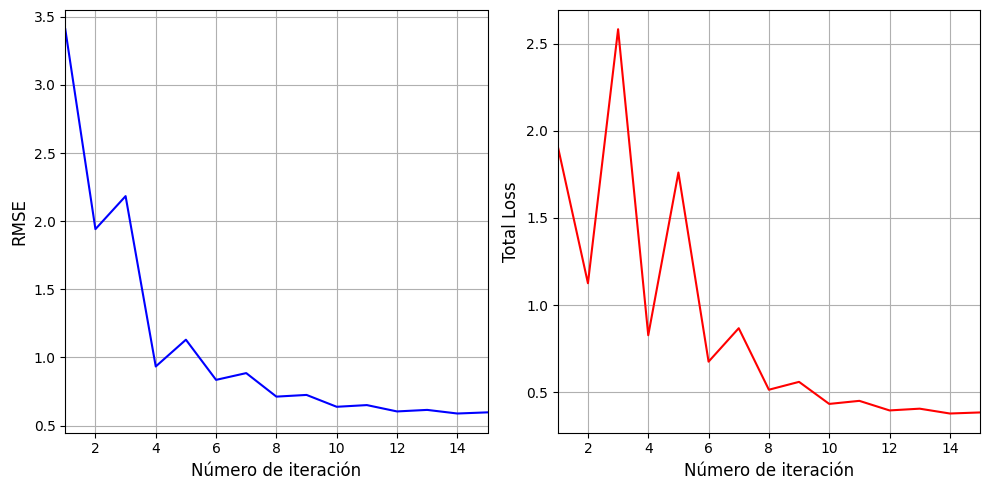

In [ ]:
x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, history.history['root_mean_squared_error'],'b')
ax[0].grid(True)
ax[0].set_xlabel('Número de iteración', fontsize = 12)
ax[0].set_ylabel('RMSE', fontsize = 12)
ax[0].set_xlim(1, 15)
ax[1].plot(x, history.history['loss'],'r')
ax[1].grid(True)
ax[1].set_xlabel('Número de iteración', fontsize = 12)
ax[1].set_ylabel('Total Loss', fontsize = 12)
ax[1].set_xlim(1, 15)
plt.tight_layout()
plt.show()

In [ ]:
df_school_seleccion_f

,RBD,NOM_RBD,DISTANCIA,SUM,COD_DEPE2,ORI_RELIGIOSA,PAGO_MATRICULA,PAGO_MENSUAL,ID_OS,SCORE,ID_NIVEL,MRUN
0,294,ESCUELA PROFESORA LJUBICA DOMIC WUTH,0.635703,0.499036,1,1,GRATUITO,GRATUITO,1,NaN,5,1
1,284,LICEO DE HOMBRES DE ANTOFAGASTA MARIO BAHAMOND...,0.657419,0.578275,1,1,GRATUITO,GRATUITO,1,NaN,5,1
2,285,LICEO BICENTENARIO MARTA NAREA DIAZ,0.674774,0.616974,1,1,GRATUITO,GRATUITO,1,NaN,5,1
3,296,ESCUELA REPUBLICA DE LOS ESTADOS UNIDOS,0.975199,0.504217,1,2,GRATUITO,GRATUITO,1,NaN,5,1
4,306,ESCUELA HUANCHACA,1.013449,0.514767,1,7,GRATUITO,SIN INFORMACION,1,NaN,5,1
5,284,LICEO DE HOMBRES DE ANTOFAGASTA MARIO BAHAMOND...,0.657419,0.578275,1,1,GRATUITO,GRATUITO,2,5.116549,5,1
6,285,LICEO BICENTENARIO MARTA NAREA DIAZ,0.674774,0.616974,1,1,GRATUITO,GRATUITO,2,5.112398,5,1
7,310,ESCUELA CLAUDIO MATTE PEREZ,1.507815,0.516158,1,1,GRATUITO,GRATUITO,2,4.844950,5,1


In [ ]:
df_school_seleccion_f[df_school_seleccion_f.ID_OS==2].reset_index(drop=True)

,RBD,NOM_RBD,DISTANCIA,SUM,COD_DEPE2,ORI_RELIGIOSA,PAGO_MATRICULA,PAGO_MENSUAL,ID_OS,SCORE,ID_NIVEL,MRUN
0,284,LICEO DE HOMBRES DE ANTOFAGASTA MARIO BAHAMOND...,0.657419,0.578275,1,1,GRATUITO,GRATUITO,2,5.116549,5,1
1,285,LICEO BICENTENARIO MARTA NAREA DIAZ,0.674774,0.616974,1,1,GRATUITO,GRATUITO,2,5.112398,5,1
2,310,ESCUELA CLAUDIO MATTE PEREZ,1.507815,0.516158,1,1,GRATUITO,GRATUITO,2,4.844950,5,1


# Seleccion de Colegios

In [ ]:
df_directorio = df_directorio_all[df_directorio_all.COD_NIVEL==id_nivel]

colegios(direccion, radio_de_busqueda, df_school_seleccion_f.merge(df_directorio), 2)

Dirección =  Antonio José de Sucre, Antofagasta, Provincia de Antofagasta, Región de Antofagasta, 1271572, Chile
Latitude =  -23.6491757
Longitude =  -70.3946115


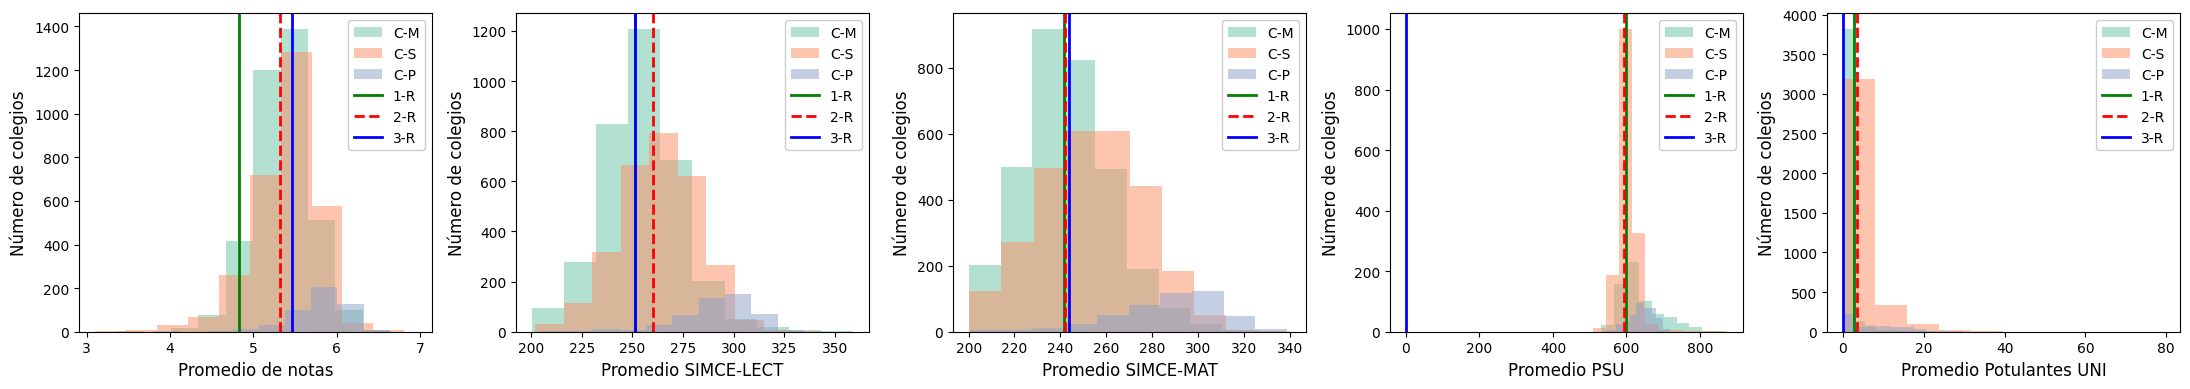

In [ ]:
# grafico un resumen las variables encontradas para los 4 colegios principales encontrados, con respecto al resto de los colegios de la RM.
import seaborn as sns
sequential_colors = sns.color_palette("Set2", 10)

# el data frame con los colegios seleccionados es el siguiente
df_Seleccion = df_school_seleccion_f[df_school_seleccion_f.ID_OS==2].reset_index(drop=True).copy()


fig, ax = plt.subplots(1,5,figsize=(22,4))
ax[0].hist(df_directorio[(df_directorio['PROM']>3) & (df_directorio['COD_DEPE2']==1)]['PROM'], color = sequential_colors[0], alpha=0.5, label='C-M')
ax[0].hist(df_directorio[(df_directorio['PROM']>3) & (df_directorio['COD_DEPE2']==2)]['PROM'], color = sequential_colors[1], alpha=0.5, label='C-S')
ax[0].hist(df_directorio[(df_directorio['PROM']>3) & (df_directorio['COD_DEPE2']==3)]['PROM'], color = sequential_colors[2], alpha=0.5, label='C-P')
ax[0].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][0]]['PROM'].iloc[0], color='g', lw=2, label='1-R')
ax[0].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][1]]['PROM'].iloc[0], color='r', ls = '--', lw=2, label='2-R')
ax[0].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][2]]['PROM'].iloc[0], color='b', lw=2, label='3-R')
#ax[0].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][3]]['PROM'].iloc[0], color='k', ls = '--', lw=2, label='4-R')
#ax[0].grid(True, color = (0.5, 0.5, 0.5, 0.05))
ax[0].set_xlabel('Promedio de notas', fontsize = 12)
ax[0].set_ylabel('Número de colegios', fontsize = 12)
ax[0].legend(facecolor='w', framealpha=1)

ax[1].hist(df_directorio[(df_directorio['SIMCE-LEC']>200) & (df_directorio['COD_DEPE2']==1)]['SIMCE-LEC'], color = sequential_colors[0], alpha=0.5, label='C-M')
ax[1].hist(df_directorio[(df_directorio['SIMCE-LEC']>200) & (df_directorio['COD_DEPE2']==2)]['SIMCE-LEC'], color = sequential_colors[1], alpha=0.5, label='C-S')
ax[1].hist(df_directorio[(df_directorio['SIMCE-LEC']>200) & (df_directorio['COD_DEPE2']==3)]['SIMCE-LEC'], color = sequential_colors[2], alpha=0.5, label='C-P')
ax[1].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][0]]['SIMCE-LEC'].iloc[0], color='g', lw=2, label='1-R')
ax[1].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][1]]['SIMCE-LEC'].iloc[0], color='r', ls = '--', lw=2, label='2-R')
ax[1].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][2]]['SIMCE-LEC'].iloc[0], color='b', lw=2, label='3-R')
#ax[1].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][3]]['SIMCE-LEC'].iloc[0], color='k', ls = '--', lw=2, label='4-R')
#ax[1].grid(True, color = (0.5, 0.5, 0.5, 0.05))
ax[1].set_xlabel('Promedio SIMCE-LECT', fontsize = 12)
ax[1].set_ylabel('Número de colegios', fontsize = 12)
ax[1].legend(facecolor='w', framealpha=1)

ax[2].hist(df_directorio[(df_directorio['SIMCE-MAT']>200) & (df_directorio['COD_DEPE2']==1)]['SIMCE-MAT'], color = sequential_colors[0], alpha=0.5, label='C-M')
ax[2].hist(df_directorio[(df_directorio['SIMCE-MAT']>200) & (df_directorio['COD_DEPE2']==2)]['SIMCE-MAT'], color = sequential_colors[1], alpha=0.5, label='C-S')
ax[2].hist(df_directorio[(df_directorio['SIMCE-MAT']>200) & (df_directorio['COD_DEPE2']==3)]['SIMCE-MAT'], color = sequential_colors[2], alpha=0.5, label='C-P')
ax[2].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][0]]['SIMCE-MAT'].iloc[0], color='g', lw=2, label='1-R')
ax[2].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][1]]['SIMCE-MAT'].iloc[0], color='r', ls = '--', lw=2, label='2-R')
ax[2].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][2]]['SIMCE-MAT'].iloc[0], color='b', lw=2, label='3-R')
#ax[2].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][3]]['SIMCE-MAT'].iloc[0], color='k', ls = '--', lw=2, label='4-R')
#ax[2].grid(True, color = (0.5, 0.5, 0.5, 0.05))
ax[2].set_xlabel('Promedio SIMCE-MAT', fontsize = 12)
ax[2].set_ylabel('Número de colegios', fontsize = 12)
ax[2].legend(facecolor='w', framealpha=1)

ax[3].hist(df_directorio[(df_directorio['PROM-PUNT']>500) & (df_directorio['COD_DEPE2']==1)]['PROM-PUNT'], color = sequential_colors[0], alpha=0.5, label='C-M')
ax[3].hist(df_directorio[(df_directorio['PROM-PUNT']>500) & (df_directorio['COD_DEPE2']==2)]['PROM-PUNT'], color = sequential_colors[1], alpha=0.5, label='C-S')
ax[3].hist(df_directorio[(df_directorio['PROM-PUNT']>500) & (df_directorio['COD_DEPE2']==3)]['PROM-PUNT'], color = sequential_colors[2], alpha=0.5, label='C-P')
ax[3].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][0]]['PROM-PUNT'].iloc[0], color='g', lw=2, label='1-R')
ax[3].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][1]]['PROM-PUNT'].iloc[0], color='r', ls = '--', lw=2, label='2-R')
ax[3].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][2]]['PROM-PUNT'].iloc[0], color='b', lw=2, label='3-R')
#ax[3].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][3]]['PROM-PUNT'].iloc[0], color='k', ls = '--', lw=2, label='4-R')
#ax[3].grid(True, color = (0.5, 0.5, 0.5, 0.05))
ax[3].set_xlabel('Promedio PSU', fontsize = 12)
ax[3].set_ylabel('Número de colegios', fontsize = 12)
ax[3].legend(facecolor='w', framealpha=1)

ax[4].hist(df_directorio[df_directorio['COD_DEPE2']==1]['PROM-POST'], color = sequential_colors[0], alpha=0.5, label='C-M')
ax[4].hist(df_directorio[df_directorio['COD_DEPE2']==2]['PROM-POST'], color = sequential_colors[1], alpha=0.5, label='C-S')
ax[4].hist(df_directorio[df_directorio['COD_DEPE2']==3]['PROM-POST'], color = sequential_colors[2], alpha=0.5, label='C-P')
ax[4].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][0]]['PROM-POST'].iloc[0], color='g', lw=2, label='1-R')
ax[4].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][1]]['PROM-POST'].iloc[0], color='r', ls = '--', lw=2, label='2-R')
ax[4].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][2]]['PROM-POST'].iloc[0], color='b', lw=2, label='3-R')
#ax[4].axvline(x=df_directorio[df_directorio.RBD==df_Seleccion['RBD'][3]]['PROM-POST'].iloc[0], color='k', ls = '--', lw=2, label='4-R')
#ax[4].grid(True, color = (0.5, 0.5, 0.5, 0.05))
ax[4].set_xlabel('Promedio Potulantes UNI', fontsize = 12)
ax[4].set_ylabel('Número de colegios', fontsize = 12)
ax[4].legend(facecolor='w', framealpha=1)

plt.tight_layout()
plt.show()